# APS Calculator - Fasting plasma glucose

## Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import decimal

## Data

In [2]:
#veri1 = pd.read_excel('/Users/hikmetcancubukcu/Desktop/18_65_nhanes_na_drop dosyalar/nhanes_20220711_fasting.xlsx')

In [3]:
veri1 = pd.read_excel('../Letter to editor ajcp imp bias/nhanes_20220711_fasting.xlsx')

### Features of fasting glucose data

In [4]:
veri1_glucose = veri1[['Fasting Glucose (mg/dL)','Fasting duration (hours)']].dropna().reset_index()



In [5]:
# Fasting duration checked and subjects with fasting duration < 8 hours were excluded

veri1 = veri1_glucose[veri1_glucose['Fasting duration (hours)']>=8].reset_index()
veri1

,level_0,index,Fasting Glucose (mg/dL),Fasting duration (hours)
0,0,1,103.0,10
1,2,8,92.0,13
2,3,9,103.0,9
3,4,10,103.0,11
4,5,12,97.0,9
...,...,...,...,...
2753,2857,5701,130.0,9
2754,2859,5703,98.0,11
2755,2860,5704,105.0,15
2756,2861,5705,102.0,11


### Fasting plasma glucose example

### Categorization

In [6]:
# Analyte column selection

column_name = 'Fasting Glucose (mg/dL)'
analyte_data = veri1[column_name]

# Numeric Analyte data to categorical data conversion

bins = [0, 99, 125, np.inf]
names = ['<100', '100-125', '≥126']

cat_analyte= pd.cut(analyte_data, bins, labels=names)

cat_analyte_df= pd.DataFrame(cat_analyte)
cat_analyte_df

# concat dfs

cat_analyte_df = cat_analyte_df.rename(columns={column_name: "Analyte_category"})

analyte_last_df = pd.concat([analyte_data, cat_analyte_df],axis = 1)

# Category to number conversion

analyte_last_df['cat_n'] = analyte_last_df['Analyte_category'].replace(
    to_replace=names,
    value=[1, 2, 3], inplace=False)

#analyte_last_df.describe()

(47.0, 451.0)

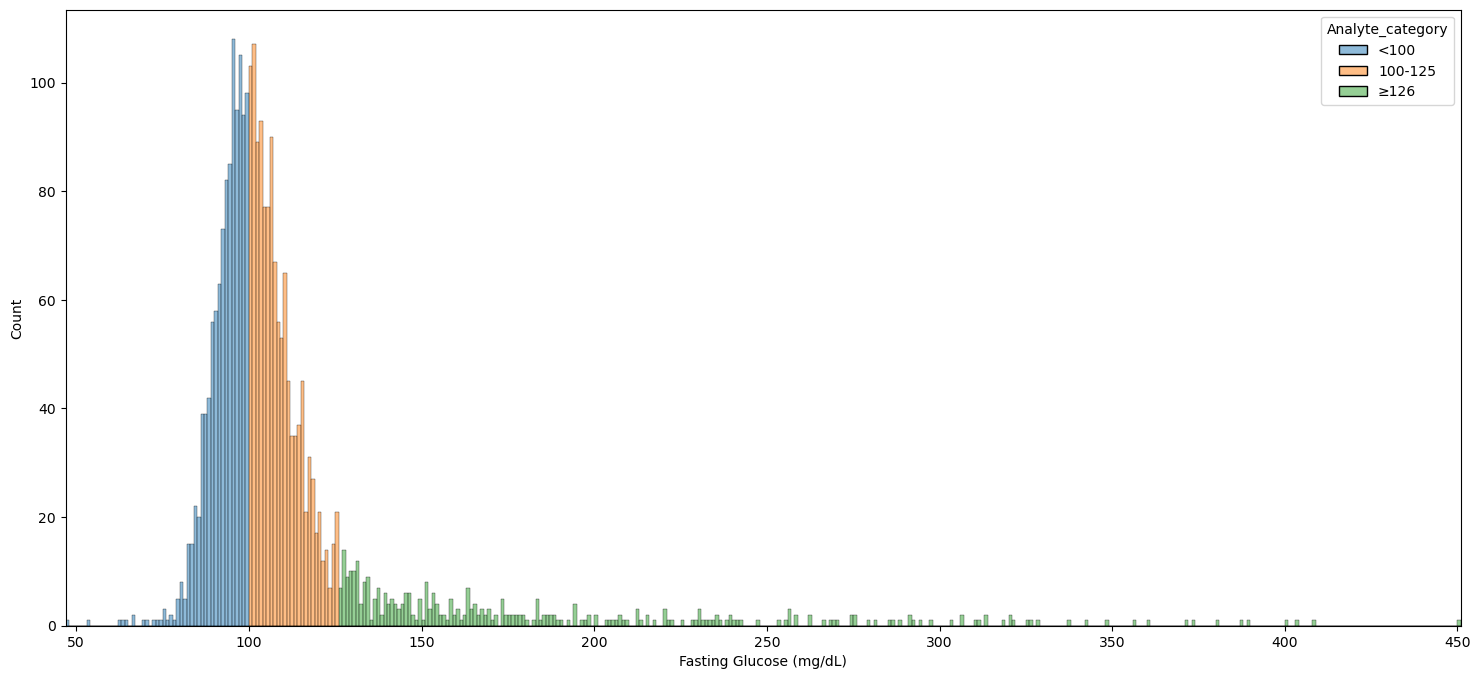

In [7]:
# histogram of original data

import seaborn as sns
import math

plt.figure(figsize=(18, 8))
sns.histplot(data=analyte_last_df, x=column_name, kde=False, hue="Analyte_category",  
             binwidth= 1, discrete= False)

plt.xlim(analyte_last_df[column_name].min(), analyte_last_df[column_name].max())

## Simulation

In [8]:
# Packages

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import jaccard_score
from numpy import random
from numpy import mean
from sklearn.metrics import precision_recall_fscore_support
import math 

# Selection of original data and original data category

od = analyte_last_df[column_name] # original data
o_cat_n = analyte_last_df['cat_n'] # original data category

### Imprecision with positive bias simulation

In [9]:
# Imprecision with positive bias

nd_list = [] # new data
kappa_score_l = [] # kappa score list
error_l = [] # imprecision list
error_l_b = [] # bias list
error_l_t = [] # total MU

accuracy_score_l = [] # accuracy score list , agreement
sub_accuracy_score_l = [] # sub_accuracy score (sub group accuracy)

n_data = len(od) # sample size
np.random.seed(1923) # seed for reproducible results
imprec_data_raw = np.random.normal(0, 1, n_data)
imprec_data_raw = pd.Series(imprec_data_raw)

# positive error simulation


for e in np.arange(0,0.1,0.001): # CV constant
    for f in np.arange(0,0.1,0.001): # bias constant
        
        n_cat_n = []
        o_cat_n = list(o_cat_n)   
        
        e_CVA=e # random error
        
        y_od = od + od*imprec_data_raw*e_CVA  # random error applied
        nd = y_od + od*f # new data, bias applied
        
        nd_cat= pd.cut(nd, bins, labels=names) # Categorization of the new data
        nd_cat_n = nd_cat.replace(to_replace=names,
        value=[1, 2, 3], inplace=False)
        n_cat_n.append(nd_cat_n)
        n_cat_n = [item for sublist in n_cat_n for item in sublist]
        
        n_cat_n = pd.Series(n_cat_n)
        n_cat_n = n_cat_n.fillna(1)
               
        kappa_score = cohen_kappa_score(o_cat_n, n_cat_n) # Kappa score
        kappa_score_l.append(kappa_score)
        error_l.append(e) # Random error rate save
        error_l_b.append(f) # bias rate save
        accuracy = accuracy_score(o_cat_n, n_cat_n) # Accuracy (Overall Agreement)
        accuracy_score_l.append(accuracy) # accuracy save
        matrix = confusion_matrix(o_cat_n, n_cat_n) # Subclass Accuracy
        matrix_2 = matrix.diagonal()/matrix.sum(axis=1)
        sub_accuracy_score_l.append(matrix_2) # Subclass Accuracy save
        
# sub_accuracy score data frame
sub_accuracy_df = pd.DataFrame(sub_accuracy_score_l)
sub_accuracy_df.columns = names

# list to series conversion
error_l = pd.Series(error_l) 
error_l_b = pd.Series(error_l_b)

kappa_score_l = pd.Series(kappa_score_l)
accuracy_score_l = pd.Series(accuracy_score_l)

# tables comprised of all data
error_kappa_table = pd.concat([error_l, error_l_b,kappa_score_l,accuracy_score_l], axis = 1)
error_kappa_table.columns = ["Imprecision", "Bias",  "Kappa Score", "Agreement"]
error_kappa_table_1 = pd.concat([error_kappa_table, sub_accuracy_df], axis = 1)

        

### Imprecision with negative bias simulation

In [10]:
# Imprecision with negative bias

nd_list = [] # new data
kappa_score_l = [] # kappa score list
error_l = [] # imprecision list
error_l_b = [] # bias list
error_l_t = [] # total MU

accuracy_score_l = [] # accuracy score list , agreement
sub_accuracy_score_l = [] # sub_accuracy score (sub group accuracy)

n_data = len(od)
np.random.seed(1923) # seed for reproducible results
imprec_data_raw = np.random.normal(0, 1, n_data)
imprec_data_raw = pd.Series(imprec_data_raw)

# negative error simulation


for e in np.arange(0,0.1,0.001): # CV constant
    for f in np.arange(0,0.1,0.001): # bias constant
        
        n_cat_n = []
        o_cat_n = list(o_cat_n)
        
        e_CVA= e # random error 
        
        y_od = od + od*imprec_data_raw*e_CVA  # random error applied
        nd = y_od - od*f # new data, bias applied
        
        nd_cat= pd.cut(nd, bins, labels=names) # Categorization of the new data
        nd_cat_n = nd_cat.replace(to_replace=names,
        value=[1, 2, 3], inplace=False)
        n_cat_n.append(nd_cat_n)
        n_cat_n = [item for sublist in n_cat_n for item in sublist]
        
        n_cat_n = pd.Series(n_cat_n)
        n_cat_n = n_cat_n.fillna(1)
        
        kappa_score = cohen_kappa_score(o_cat_n, n_cat_n) # Kappa score
        kappa_score_l.append(kappa_score)
        error_l.append(e) # Random error rate save
        error_l_b.append(-f) # bias rate save
        accuracy = accuracy_score(o_cat_n, n_cat_n) # Accuracy (Overall Agreement)
        accuracy_score_l.append(accuracy) # accuracy save
        matrix = confusion_matrix(o_cat_n, n_cat_n) # Subclass Accuracy
        matrix_2 = matrix.diagonal()/matrix.sum(axis=1)
        sub_accuracy_score_l.append(matrix_2) # Subclass Accuracy save
        
# sub_accuracy score data frame
sub_accuracy_df = pd.DataFrame(sub_accuracy_score_l)
sub_accuracy_df.columns = names

# list to series conversion
error_l = pd.Series(error_l) 
error_l_b = pd.Series(error_l_b)

kappa_score_l = pd.Series(kappa_score_l)
accuracy_score_l = pd.Series(accuracy_score_l)

# tables comprised of all data
error_kappa_table = pd.concat([error_l, error_l_b, kappa_score_l,accuracy_score_l], axis = 1)
error_kappa_table.columns = ["Imprecision", "Bias",  "Kappa Score", "Agreement"]
error_kappa_table_1_1 = pd.concat([error_kappa_table, sub_accuracy_df], axis = 1)
error_kappa_table_2 = pd.concat([error_kappa_table_1, error_kappa_table_1_1], axis = 0) # concat positive and negative error simulation data



In [11]:
# Concat positive and negative bias simulation data

error_kappa_table_2 = pd.concat([error_kappa_table_1, error_kappa_table_1_1], axis = 0) # concat positive and negative error simulation data
error_kappa_table_2 = error_kappa_table_2.reset_index() # reset index


## Disagreement based calculation

In [12]:
# Agreement categorization

bins_k = [0, 0.90, 0.95, 0.99, np.inf]
names_k = ['0-90','90-95', '95-99', '>99']

cat_DA= pd.cut(error_kappa_table_2['Agreement'], bins_k, labels=names_k)

cat_DA_df= pd.DataFrame(cat_DA)
cat_DA_df

# concat dfs

cat_DA_df = cat_DA_df.rename(columns={"Agreement": "Agreement Category"})

# Outcome full
error_kappa_table_2_v2 = pd.concat([error_kappa_table_2, cat_DA_df],axis = 1)



error_DA_table_2_v2 = error_kappa_table_2_v2[error_kappa_table_2_v2['Agreement']>0.75]
error_DA_table_2_v2 = error_DA_table_2_v2.reset_index() # reset index
error_DA_table_2_v2

,level_0,index,Imprecision,Bias,Kappa Score,Agreement,<100,100-125,≥126,Agreement Category
0,0,0,0.00,0.000,1.000000,1.000000,1.000000,1.000000,1.000000,>99
1,1,1,0.00,0.001,0.928491,0.956853,0.914485,0.983333,1.000000,95-99
2,2,2,0.00,0.002,0.928491,0.956853,0.914485,0.983333,1.000000,95-99
3,3,3,0.00,0.003,0.928491,0.956853,0.914485,0.983333,1.000000,95-99
4,4,4,0.00,0.004,0.928491,0.956853,0.914485,0.983333,1.000000,95-99
...,...,...,...,...,...,...,...,...,...,...
10499,19007,9007,0.09,-0.007,0.589609,0.750544,0.770506,0.694444,0.886364,0-90
10500,19008,9008,0.09,-0.008,0.590135,0.750906,0.773997,0.692063,0.886364,0-90
10501,19009,9009,0.09,-0.009,0.590196,0.750906,0.776614,0.689683,0.886364,0-90
10502,19011,9011,0.09,-0.011,0.590156,0.750906,0.780977,0.685714,0.886364,0-90


# Visiualisation of Data

## 3D Scatter Plot

<class 'mpl_toolkits.mplot3d.axes3d.Axes3D'>


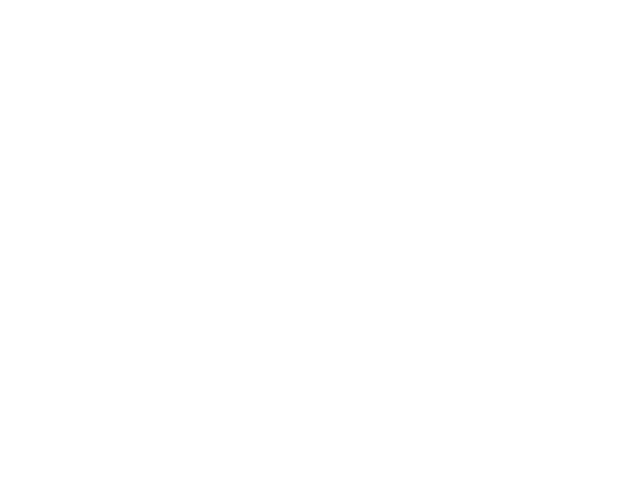

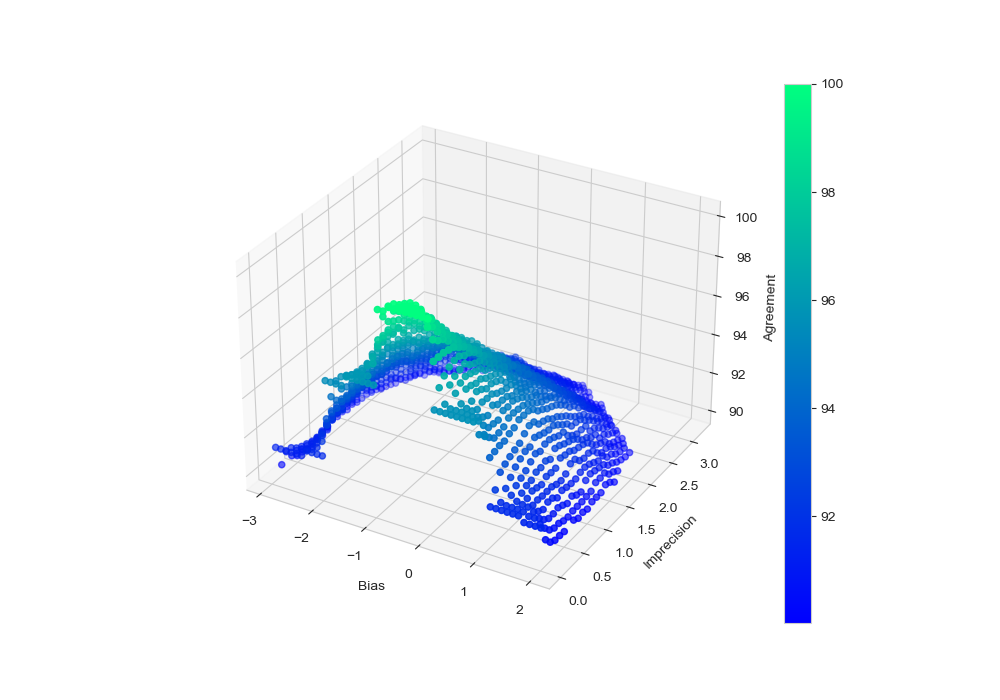

In [19]:
# 3d Scattter Plot

import ipympl
%matplotlib widget
from mpl_toolkits.axes_grid1 import make_axes_locatable

sns.set_style('whitegrid')
plt.figure(figsize=(10,7))

axes = plt.axes(projection='3d')

color_map = plt.get_cmap('winter')
error_DA_table_2_v22 = error_DA_table_2_v2[error_DA_table_2_v2['Agreement']>=0.90]

print(type(axes))
x1 = error_DA_table_2_v22['Bias']*100 # percentage unit
y1 = error_DA_table_2_v22['Imprecision']*100 # percentage unit
z1 = error_DA_table_2_v22['Agreement']*100

scatter_plot= axes.scatter3D(x1, y1, z1, c=(z1),
                            cmap = color_map
                            )

axes.set_xlabel('Bias')
axes.set_ylabel('Imprecision')
axes.set_zlabel('Agreement')

axes.view_init()

plt.colorbar(scatter_plot)
plt.figure(constrained_layout=True)

plt.show()

## Contour Plot

(0.0, 4.2)

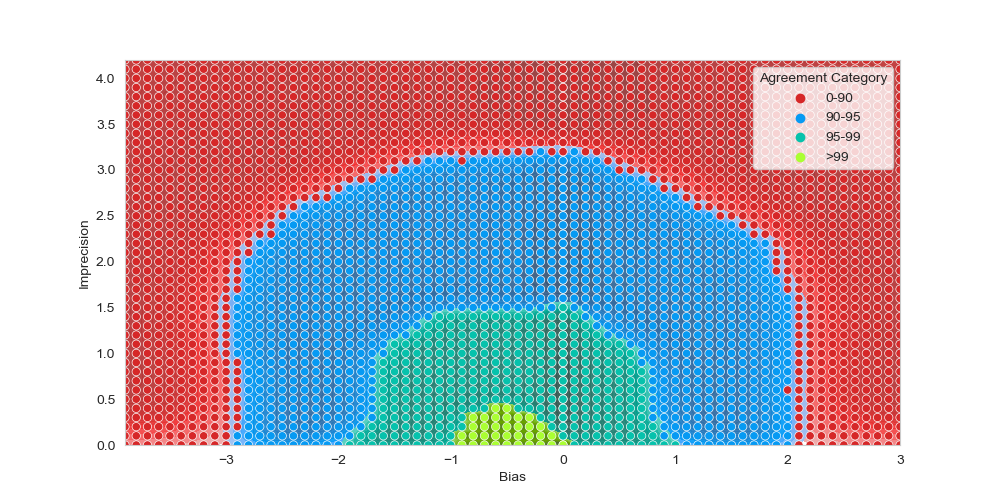

In [16]:

# percentage unit conversion by multiplying 100

error_DA_table_2_v3 = error_DA_table_2_v2[['Imprecision','Bias','Agreement']].apply(lambda x: x*100) # percentage unit conversion
error_DA_table_2_v3 = pd.concat([error_DA_table_2_v3, error_DA_table_2_v2[['Agreement Category','Kappa Score']]], axis = 1) # concat 

                                              
# contour plot
import matplotlib.colors as mcolors

plt.figure(figsize=(10, 5))
palette = ['tab:red', 'xkcd:azure', 'xkcd:turquoise', 'xkcd:lime']
palette2 = ['tab:red', 'xkcd:azure', 'xkcd:turquoise', 'xkcd:lime']
sns.kdeplot(data=error_DA_table_2_v3, x="Bias",y = "Imprecision",hue = 'Agreement Category', fill=True
            ,palette=palette, common_norm=False,levels=30, alpha=0.95,warn_singular=False, bw_adjust=0.5
            ,bw_method='scott',weights='Agreement')
sns.scatterplot(data=error_DA_table_2_v3, x="Bias",y = "Imprecision", hue = 'Agreement Category' ,palette=palette2)


error_DA_table_3_v3 = error_DA_table_2_v3[error_DA_table_2_v3['Agreement']>90] # for x and y axis limit adjustment 
limit_xn = error_DA_table_3_v3['Bias'].min()
limit_xp = error_DA_table_3_v3['Bias'].max()
ylim_v1 = error_DA_table_3_v3['Imprecision'].max()

plt.xlim(limit_xn-1, limit_xp + 1)
plt.ylim(0, ylim_v1+1)

## APF for MU based on overall agreement

In [17]:
# APS for MU

# APS levels allocation based on Kappa value
error_kappa_table_3 = error_DA_table_2_v2[(error_DA_table_2_v2['Agreement']>=0.90) & (error_DA_table_2_v2['Agreement']<0.95)]
error_kappa_table_4 = error_DA_table_2_v2[(error_DA_table_2_v2['Agreement']>=0.95) & (error_DA_table_2_v2['Agreement']<0.99)]
error_kappa_table_5 = error_DA_table_2_v2[error_DA_table_2_v2['Agreement']>=0.99]

# generation of dataframe
data_aps = {'APS level': ['Minimum', 'Desirable', 'Optimum'],
        'Imprecision': [error_kappa_table_3['Imprecision'].max(), error_kappa_table_4['Imprecision'].max(), error_kappa_table_5['Imprecision'].max()],
       'Positive Bias': [error_kappa_table_3['Bias'].max(), error_kappa_table_4['Bias'].max(), error_kappa_table_5['Bias'].max()],
       'Negative Bias': [error_kappa_table_3['Bias'].min(), error_kappa_table_4['Bias'].min(), error_kappa_table_5['Bias'].min()],
        'Minimum Accuracy (Agreement)': [error_kappa_table_3['Agreement'].min(), error_kappa_table_4['Agreement'].min(), error_kappa_table_5['Agreement'].min()],
           'Maximum Accuracy (Agreement)': [error_kappa_table_3['Agreement'].max(), error_kappa_table_4['Agreement'].max(), error_kappa_table_5['Agreement'].max()]}
data_aps = pd.DataFrame(data_aps)

data_aps.loc[data_aps['Positive Bias'] < 0, 'Positive Bias'] = 0 # replace values are not found > 0 with 0

data_aps_v2= data_aps[['Imprecision','Positive Bias','Negative Bias','Minimum Accuracy (Agreement)', 'Maximum Accuracy (Agreement)']]*100

# APS level as first column 
data_aps_v2['APS level'] = ['Minimum (%)', 'Desirable (%)', 'Optimum (%)']
first_column = data_aps_v2.pop('APS level') 
data_aps_v2.insert(0, 'APS level', first_column)


data_aps_v2

,APS level,Imprecision,Positive Bias,Negative Bias,Minimum Accuracy (Agreement),Maximum Accuracy (Agreement)
0,Minimum (%),3.2,2.0,-2.9,90.029007,94.996374
1,Desirable (%),1.5,1.0,-1.9,95.032632,98.984772
2,Optimum (%),0.4,-0.0,-0.9,99.093546,100.000000


## APS for MU for subclassification aggreement

In [18]:
# APS for MU for subclassification aggreement

# APS levels allocation based on Kappa value
error_kappa_table_3 = error_DA_table_2_v2[(error_DA_table_2_v2['Agreement']>=0.90) 
                                         & (error_DA_table_2_v2['<100']>=0.90)
                                         & (error_DA_table_2_v2['100-125']>=0.90)
                                         & (error_DA_table_2_v2['≥126']>=0.90)]
error_kappa_table_4 = error_DA_table_2_v2[(error_DA_table_2_v2['Agreement']>=0.95) 
                                         & (error_DA_table_2_v2['<100']>=0.95)
                                         & (error_DA_table_2_v2['100-125']>=0.95)
                                         & (error_DA_table_2_v2['≥126']>=0.95) ]
error_kappa_table_5 = error_DA_table_2_v2[(error_DA_table_2_v2['Agreement']>=0.99)
                                         & (error_DA_table_2_v2['<100']>=0.99)
                                         & (error_DA_table_2_v2['100-125']>=0.99)
                                         & (error_DA_table_2_v2['≥126']>=0.99)]

# generation of dataframe
data_aps = {'APS level': ['Minimum', 'Desirable', 'Optimum'],
        'Imprecision': [error_kappa_table_3['Imprecision'].max(), error_kappa_table_4['Imprecision'].max(), error_kappa_table_5['Imprecision'].max()],
       'Positive Bias': [error_kappa_table_3['Bias'].max(), error_kappa_table_4['Bias'].max(), error_kappa_table_5['Bias'].max()],
       'Negative Bias': [error_kappa_table_3['Bias'].min(), error_kappa_table_4['Bias'].min(), error_kappa_table_5['Bias'].min()],
        'Minimum Accuracy (Agreement)': [error_kappa_table_3['Agreement'].min(), error_kappa_table_4['Agreement'].min(), error_kappa_table_5['Agreement'].min()],
           'Maximum Accuracy (Agreement)': [error_kappa_table_3['Agreement'].max(), error_kappa_table_4['Agreement'].max(), error_kappa_table_5['Agreement'].max()]}
data_aps = pd.DataFrame(data_aps)

data_aps.loc[data_aps['Positive Bias'] < 0, 'Positive Bias'] = 0 # replace values are not found > 0 with 0

data_aps_v2= data_aps[['Imprecision','Positive Bias','Negative Bias','Minimum Accuracy (Agreement)', 'Maximum Accuracy (Agreement)']]*100

# APS level as first column 
data_aps_v2['APS level'] = ['Minimum (%)', 'Desirable (%)', 'Optimum (%)']
first_column = data_aps_v2.pop('APS level') 
data_aps_v2.insert(0, 'APS level', first_column)


data_aps_v2

,APS level,Imprecision,Positive Bias,Negative Bias,Minimum Accuracy (Agreement),Maximum Accuracy (Agreement)
0,Minimum (%),2.9,1.0,-1.9,91.007977,100.0
1,Desirable (%),1.4,-0.0,-1.1,95.431472,100.0
2,Optimum (%),0.4,-0.0,-0.8,99.166062,100.0


# 

# ---------------------------------------------------------------------------------------
# End of APS Calculation
# ---------------------------------------------------------------------------------------